In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.chdir("../")

In [2]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
# from datasets.dataset_load import dataset_loader
# Make plots inline
%matplotlib inline

device="cpu"

In [3]:
import os
from config import Config
import pandas as pd

In [4]:
# def load_data(appliance):
#     # Load data
#     if os.path.exists(os.path.join(Config.data_path, appliance)):
#         X_train = pd.read_csv(
#             os.path.join(Config.data_path, appliance,
#                          "x_train.csv.gz")
#         )
#         y_train = pd.read_csv(
#             os.path.join(Config.data_path, appliance,
#                          "y_train.csv.gz")
#         )
#         X_train = torch.tensor(X_train.to_numpy()).float()
#         y_train = torch.tensor(y_train.to_numpy()).float()
       
#         X_test = pd.read_csv(
#             os.path.join(Config.data_path, appliance,
#                             "x_test.csv.gz")
#         )
#         y_test = pd.read_csv(
#             os.path.join(Config.data_path, appliance,
#                             "y_test.csv.gz")
#         )
#         X_test = torch.tensor(X_test.to_numpy()).float()
#         y_test = torch.tensor(y_test.to_numpy()).float()
#         return (
#             X_train.contiguous().to(device),
#             y_train.contiguous().to(device).ravel(),
#             X_test.contiguous().to(device),
#             y_test.contiguous().to(device).ravel(),
#         )
#         # return X_train.to(device), y_train.to(device).ravel()
#     else:
#         raise ValueError("Data not found at", Config.data_path)

In [5]:
# train_x, train_y, test_x, test_y = load_data("Refrigerator")

# print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

In [6]:
train ={1:{
                    'start_time': "2011-04-21" ,
                    'end_time': "2011-05-21"
                },
                3: {
                    'start_time': "2011-04-19" ,
                    'end_time': "2011-05-22"
                },
                2: {
                    'start_time': "2011-04-21" ,
                    'end_time': "2011-05-21"
                },
                5: {
                    'start_time': "2011-04-22" ,
                    'end_time': "2011-06-01"
                }
                }
test = {6: {
                    'start_time': "2011-05-25" ,
                    'end_time': "2011-06-13"
                }}
appliances = ["Refrigerator"]

In [20]:
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import torch

def dataset_loader(appliances, train, test=None):
    x_train = []
    y_train = []
    x_train_timestamp = []
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    scaler_time = StandardScaler()
    # train
    for key, values in train.items():
        df = pd.read_csv(
            f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
        df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
        startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
        endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()
        

        if startDate > endDate:
            raise "Start Date must be smaller than Enddate."

        df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
        df.dropna(inplace=True)
        x = df["main"].values
        y = df[appliances[0]].values
        
        timestamp_train = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values

        x_train.extend(torch.tensor(x))
        y_train.extend(torch.tensor(y))
        x_train_timestamp.extend(torch.tensor(timestamp_train))

    x_train = torch.tensor(x_train).reshape(-1, 1)
    y_train = torch.tensor(y_train).reshape(-1, 1)
    x_train_timestamp = torch.tensor(x_train_timestamp).reshape(-1,1)
    x_train = scaler_x.fit_transform(x_train)
    y_train = scaler_y.fit_transform(y_train)
    x_train_timestamp = scaler_time.fit_transform(x_train_timestamp)


    # test
    x_test = []
    y_test = []
    x_test_timestamp = []
    for key, values in test.items():
        df = pd.read_csv(
            f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
        df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
        startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
        endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

        if startDate > endDate:
            raise "Start Date must be smaller than Enddate."

        df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
        df.dropna(inplace=True)
        x = df["main"].values
        y = df[appliances[0]].values
        timestamp = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values

        x_test.extend(torch.tensor(x))
        y_test.extend(torch.tensor(y))
        x_test_timestamp.extend(timestamp)

    x_test = torch.tensor(x_test).reshape(-1, 1)
    y_test = torch.tensor(y_test).reshape(-1, 1)
    x_test_timestamp = torch.tensor(x_test_timestamp).reshape(-1,1)

    x_test = scaler_x.transform(x_test)
    x_test_timestamp = scaler_time.transform(x_test_timestamp)

    x_train = torch.tensor(x_train).reshape(x_train.shape[0], 1).contiguous().to(device)
    y_train = torch.tensor(y_train).reshape(-1,).contiguous().to(device)
    x_train_timestamp = torch.tensor(x_train_timestamp).reshape(x_train_timestamp.shape[0], 1).contiguous().to(device)
    x_test = torch.tensor(x_test).reshape(x_test.shape[0], 1).contiguous().to(device)
    y_test = torch.tensor(y_test).reshape(-1,).contiguous().to(device)
    x_test_timestamp = torch.tensor(x_test_timestamp).reshape(x_test_timestamp.shape[0], 1).contiguous().to(device)


    return x_train, y_train, x_test, y_test, x_train_timestamp, x_test_timestamp, scaler_x, scaler_y


In [21]:
train_x, train_y, test_x, test_y, x_train_timestamp, x_test_timestamp, scaler_x, scaler_y = dataset_loader(appliances, train, test)
print(train_x.shape)

x_train  = train_x
y_train = train_y
x_test = test_x

torch.Size([53456, 1])


/tmp/ipykernel_1175833/1686164960.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).reshape(-1,).contiguous().to(device)


In [22]:
import numpy as np

len(np.unique(x_train_timestamp)), len(x_train_timestamp)

(29836, 53456)

In [24]:
x_train_timestamp.max(), x_train_timestamp.min()

(tensor(3.2119, dtype=torch.float64), tensor(-1.1593, dtype=torch.float64))

(array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 array([-1.15925827, -0.72214043, -0.2850226 ,  0.15209523,  0.58921307,
         1.0263309 ,  1.46344873,  1.90056657,  2.3376844 ,  2.77480223,
         3.21192006]),
 <a list of 53456 BarContainer objects>)

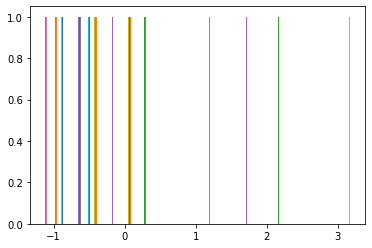

In [25]:
plt.hist(x_train_timestamp)

In [11]:
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel, PeriodicKernel
from gpytorch.distributions import MultivariateNormal

class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        kernel1 = ScaleKernel(RBFKernel(ard_num_dims=train_x.shape[1]))
        kernel2 = ScaleKernel(RBFKernel(ard_num_dims=train_x.shape[1]))
        kernel3 = ScaleKernel(PeriodicKernel(ard_num_dims=train_x.shape[1]))

        kernel = kernel1 + kernel2*kernel3
        self.base_covar_module = kernel
        self.covar_module = InducingPointKernel(self.base_covar_module, inducing_points=train_x[np.arange(0, train_x.shape[0], 10),:], likelihood=likelihood)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [17]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(x_train, y_train, likelihood)

# if torch.cuda.is_available():
#     model = model.cuda()
#     likelihood = likelihood.cuda()

In [13]:
# x_train, y_train, x_test, y_test, x_test_timestamp, scaler_x, scaler_y = dataset_loader(appliances, train, test)
      

In [18]:
training_iterations = 50
loss_arr = []
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

x_train = x_train[:45000]
y_train = y_train[:45000]

def train():
    for i in range(training_iterations):
        # x_train, y_train, x_test, y_test, x_test_timestamp, scaler_x, scaler_y = dataset_loader(appliances, train, test)
        # print("first 500", x_train[:500,:])
        # print("After 500", x_train[500:,:])
        # print(i)
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(x_train.to("cuda"))
        # Calc loss and backprop derivatives
        loss = -mll(output, y_train.to("cuda"))
        loss_arr.append(loss)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.step()
        torch.cuda.empty_cache()

# See dkl_mnist.ipynb for explanation of this flag
%time train()


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument other in method wrapper__equal)

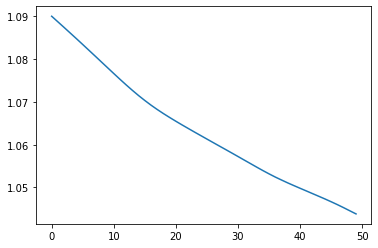

In [15]:
loss_ar1 = []
for i in range(len(loss_arr)):
  loss_ar1.append(loss_arr[i].detach().numpy())
import numpy as np
plt.plot((loss_ar1))

In [16]:
model.eval()
likelihood.eval()
with gpytorch.settings.max_preconditioner_size(10), torch.no_grad():
    preds = model(test_x)

In [17]:
print('Test MAE: {}'.format(torch.mean(torch.abs(preds.mean - test_y))))

Test MAE: 75.49340057373047


In [18]:
y_mean = scaler_y.inverse_transform(preds.mean.reshape(-1,1)).squeeze()

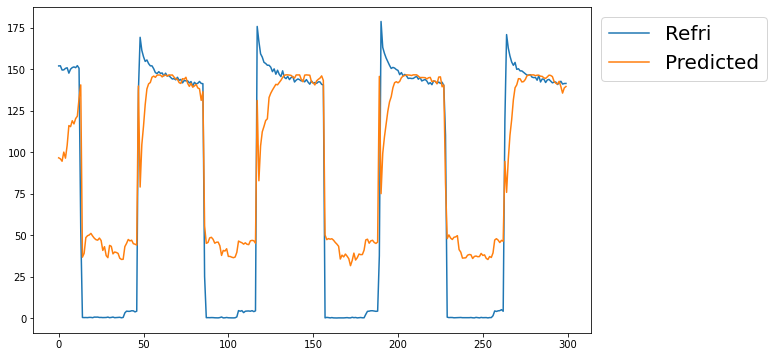

In [19]:
idx = 300
plt.figure(figsize=(10,6))
plt.plot(jnp.arange(idx), test_y.cpu()[:idx], label = "Refri")
plt.plot(jnp.arange(idx), y_mean[:idx], label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
# sns.despine()
plt.savefig("gp_ref_full_per+rbf.png", bbox_inches="tight")

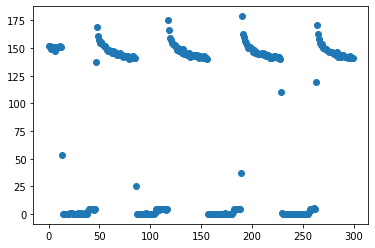

In [21]:
plt.scatter(jnp.arange(idx),test_y.cpu()[:idx])

Trial

In [32]:
x = torch.rand(10,1)
y = torch.rand(10,)

print(x)
from skgpytorch.models import SGPRegressor

kernel = ScaleKernel(RBFKernel(ard_num_dims=1))
model = SGPRegressor(x.to("cuda"),y.to("cuda"), kernel, inducing_points=x[:5]).to("cuda")

model.fit(lr=0.1, n_epochs=10,
                  random_state=0, batch_size=None)

tensor([[0.4963],
        [0.7682],
        [0.0885],
        [0.1320],
        [0.3074],
        [0.6341],
        [0.4901],
        [0.8964],
        [0.4556],
        [0.6323]])


In [33]:
print(x)

tensor([[0.4963],
        [0.7682],
        [0.0885],
        [0.1320],
        [0.3074],
        [0.6341],
        [0.4901],
        [0.8964],
        [0.4556],
        [0.6323]])
